In [1]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy.stats import ks_2samp, mannwhitneyu, wasserstein_distance, norm
from pathlib import Path
from datasets import load_dataset

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

# Configure visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


# Training Dataset vs VAE-Generated Tags Comparison

This notebook compares the original training dataset with VAE-generated tags dataset to validate the generation quality and assess how well the VAE preserves the statistical properties of the original data.


## Load and Prepare Datasets


In [2]:
KNOWN_TAGS = json.load(open("../data/concepts_to_tags.json", "r"))

# Reverse map for easy lookup (tag -> category)
TAG_TO_CATEGORY = {}
for cat, tags in KNOWN_TAGS.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat

ALL_TAGS = set([tag for tags in KNOWN_TAGS.values() for tag in tags])

In [3]:
# Parse tags into categories
def parse_tags(tags):
    # filter out unknown tags
    tags = [t for t in tags if t in TAG_TO_CATEGORY]
    return pd.Series({
        'genre_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'genre'],
        'mood_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'mood'],
        'instrument_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'instrument'],
        'tempo_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'tempo']
    })

In [4]:
df_mc = load_dataset("google/MusicCaps", split="train").to_pandas()
df_mc['aspect_list'] = df_mc['aspect_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
tag_categories_mc = df_mc['aspect_list'].apply(parse_tags)
df_mc = pd.concat([df_mc, tag_categories_mc], axis=1)

print("\nMusicCaps Dataset Loaded")
print(f"  Shape: {df_mc.shape}")
print(f"  Sample row:")
print(df_mc.iloc[0])


MusicCaps Dataset Loaded
  Shape: (5521, 13)
  Sample row:
ytid                                                              -0Gj8-vB1q4
start_s                                                                    30
end_s                                                                      40
audioset_positive_labels                         /m/0140xf,/m/02cjck,/m/04rlf
aspect_list                 [low quality, sustained strings melody, soft f...
caption                     The low quality recording features a ballad so...
author_id                                                                   4
is_balanced_subset                                                      False
is_audioset_eval                                                         True
genre_tags                                                  [soulful, ballad]
mood_tags                                                               [sad]
instrument_tags                                                            []
temp

In [5]:

# Load VAE-generated dataset
df_vae = pd.read_csv("../data/vae-tags-dataset/all.csv")
df_vae = df_vae.reset_index(drop=True)
df_vae = df_vae.fillna('')

# Parse tag strings and list representations
df_vae['aspect_list'] = df_vae['aspect_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df_vae['mood_tags'] = df_vae['mood_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df_vae['genre_tags'] = df_vae['genre_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df_vae['instrument_tags'] = df_vae['instrument_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df_vae['tempo_tags'] = df_vae['tempo_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

print("\nVAE-Generated Dataset Loaded")
print(f"  Shape: {df_vae.shape}")
print(f"  Unique temperatures: {df_vae['temperature'].unique()}")
print(f"  Sample row:")
print(df_vae.iloc[0])


VAE-Generated Dataset Loaded
  Shape: (23815, 8)
  Unique temperatures: [2.   1.   0.5  0.75 0.25 1.25 1.75 1.5 ]
  Sample row:
aspect_list               [acoustic guitar, pop, uptempo]
original_aspect_list    ['pop', 'funk', 'rock', 'guitar']
temperature                                           2.0
instrument_tags                         [acoustic guitar]
genre_tags                                          [pop]
mood_tags                                              []
tempo_tags                                      [uptempo]
id                       d59ad550f7f046fbc63513a684e30a87
Name: 0, dtype: object


In [6]:
# Load random tags dataset
df_random = pd.read_csv("../data/random-tags-dataset/all.csv")
df_random = df_random.reset_index(drop=True)
df_random = df_random.fillna('')

# Parse tag strings and list representations
df_random['aspect_list'] = df_random['aspect_list'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_random['mood_tags'] = df_random['mood_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_random['genre_tags'] = df_random['genre_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_random['instrument_tags'] = df_random['instrument_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_random['tempo_tags'] = df_random['tempo_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

print("\nRandom Tags Dataset Loaded")
print(f"  Shape: {df_random.shape}")
print(f"  Sample row:")
print(df_random.iloc[0])


Random Tags Dataset Loaded
  Shape: (12000, 6)
  Sample row:
instrument_tags                                        [punchy kick]
mood_tags          [happy,  passionate,  scary,  eerie,  upliftin...
genre_tags                        [ambient sounds,  dance,  soulful]
tempo_tags                     [fast tempo,  uptempo,  dance groove]
aspect_list        [punchy kick,  happy,  passionate,  scary,  ee...
id                                                       sample_0000
Name: 0, dtype: object


In [7]:

# For easier comparison, focus on a single temperature (use 1.0 as baseline)
df_vae_baseline = df_vae[df_vae['temperature'] == 1.0].reset_index(drop=True)

print(f"\nUsing VAE dataset at temperature=1.0")
print(f"  Shape: {df_vae_baseline.shape}")


Using VAE dataset at temperature=1.0
  Shape: (4938, 8)


## Compute Tag Distribution Statistics


In [8]:

# Define tag categories for comparison
tag_categories = {
    'Tempo': 'tempo_tags',
    'Genre': 'genre_tags',
    'Mood': 'mood_tags',
    'Instrument': 'instrument_tags',
    'All Tags': 'aspect_list'
}

# Compute statistics for each category
stats_data = []

for cat_name, col in tag_categories.items():
    train_counts = df_mc[col].apply(len)
    vae_counts = df_vae_baseline[col].apply(len)
    random_counts = df_random[col].apply(len)
    
    stats_data.append({
        'Category': cat_name,
        'Dataset': 'MusicCaps',
        'Mean': train_counts.mean(),
        'Median': train_counts.median(),
        'Std': train_counts.std(),
        'Min': train_counts.min(),
        'Max': train_counts.max(),
        'Q25': train_counts.quantile(0.25),
        'Q75': train_counts.quantile(0.75),
        'Count': len(train_counts)
    })
    
    stats_data.append({
        'Category': cat_name,
        'Dataset': 'VAE-Generated',
        'Mean': vae_counts.mean(),
        'Median': vae_counts.median(),
        'Std': vae_counts.std(),
        'Min': vae_counts.min(),
        'Max': vae_counts.max(),
        'Q25': vae_counts.quantile(0.25),
        'Q75': vae_counts.quantile(0.75),
        'Count': len(vae_counts)
    })

    stats_data.append({
        'Category': cat_name,
        'Dataset': 'Random Tags',
        'Mean': random_counts.mean(),
        'Median': random_counts.median(),
        'Std': random_counts.std(),
        'Min': random_counts.min(),
        'Max': random_counts.max(),
        'Q25': random_counts.quantile(0.25),
        'Q75': random_counts.quantile(0.75),
        'Count': len(random_counts)
    })

stats_df = pd.DataFrame(stats_data)

print("\n" + "="*100)
print("TAG COUNT STATISTICS COMPARISON")
print("="*100)
print(stats_df.to_string(index=False))



TAG COUNT STATISTICS COMPARISON
  Category       Dataset      Mean  Median      Std  Min  Max  Q25  Q75  Count
     Tempo     MusicCaps  0.605144     0.0 0.743963    0    6  0.0  1.0   5521
     Tempo VAE-Generated  1.374241     1.0 0.904203    0    6  1.0  2.0   4938
     Tempo   Random Tags  2.011917     1.0 1.421188    1    7  1.0  3.0  12000
     Genre     MusicCaps  0.502626     0.0 0.769695    0    8  0.0  1.0   5521
     Genre VAE-Generated  1.398744     1.0 1.023906    0    7  1.0  2.0   4938
     Genre   Random Tags  2.782000     2.0 2.361802    1   13  1.0  4.0  12000
      Mood     MusicCaps  0.984423     1.0 1.235984    0    8  0.0  2.0   5521
      Mood VAE-Generated  2.149656     2.0 1.689990    0   10  1.0  3.0   4938
      Mood   Random Tags  2.665833     2.0 1.932048    1   10  1.0  4.0  12000
Instrument     MusicCaps  1.286905     1.0 1.321611    0    6  0.0  2.0   5521
Instrument VAE-Generated  2.945119     3.0 1.829259    0   11  2.0  4.0   4938
Instrument   Random

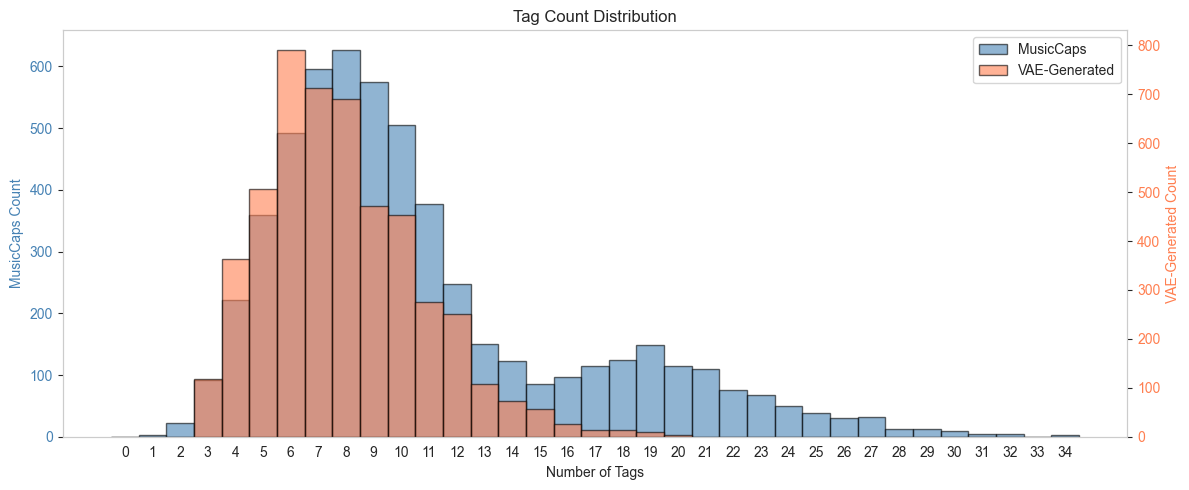

In [9]:
# Compare tag distributions visually
fig, ax = plt.subplots(figsize=(12, 5))
ax1 = ax
ax2 = ax.twinx()

train_counts = df_mc['aspect_list'].apply(len)
vae_counts = df_vae_baseline['aspect_list'].apply(len)

# Create bins
max_count = max(train_counts.max(), vae_counts.max())
bins = np.arange(0, max_count + 2)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms
n1, _, patches1 = ax1.hist(train_counts, bins=bins, alpha=0.6, label='MusicCaps', color='steelblue', edgecolor='black')
n2, _, patches2 = ax2.hist(vae_counts, bins=bins, alpha=0.6, label='VAE-Generated', color='coral', edgecolor='black')

# Center x-axis labels to bars
ax1.set_xticks(bin_centers)
ax1.set_xticklabels([str(int(bc)) for bc in bin_centers])

ax1.set_xlabel('Number of Tags')
ax1.set_ylabel('MusicCaps Count', color='steelblue')
ax2.set_ylabel('VAE-Generated Count', color='coral')

ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='coral')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2

ax1.legend(handles, labels, loc='upper right')
ax1.set_title(f'Tag Count Distribution')
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.savefig("../docs/assets/tag_count_distribution_comparison.pdf", bbox_inches='tight')
plt.show()

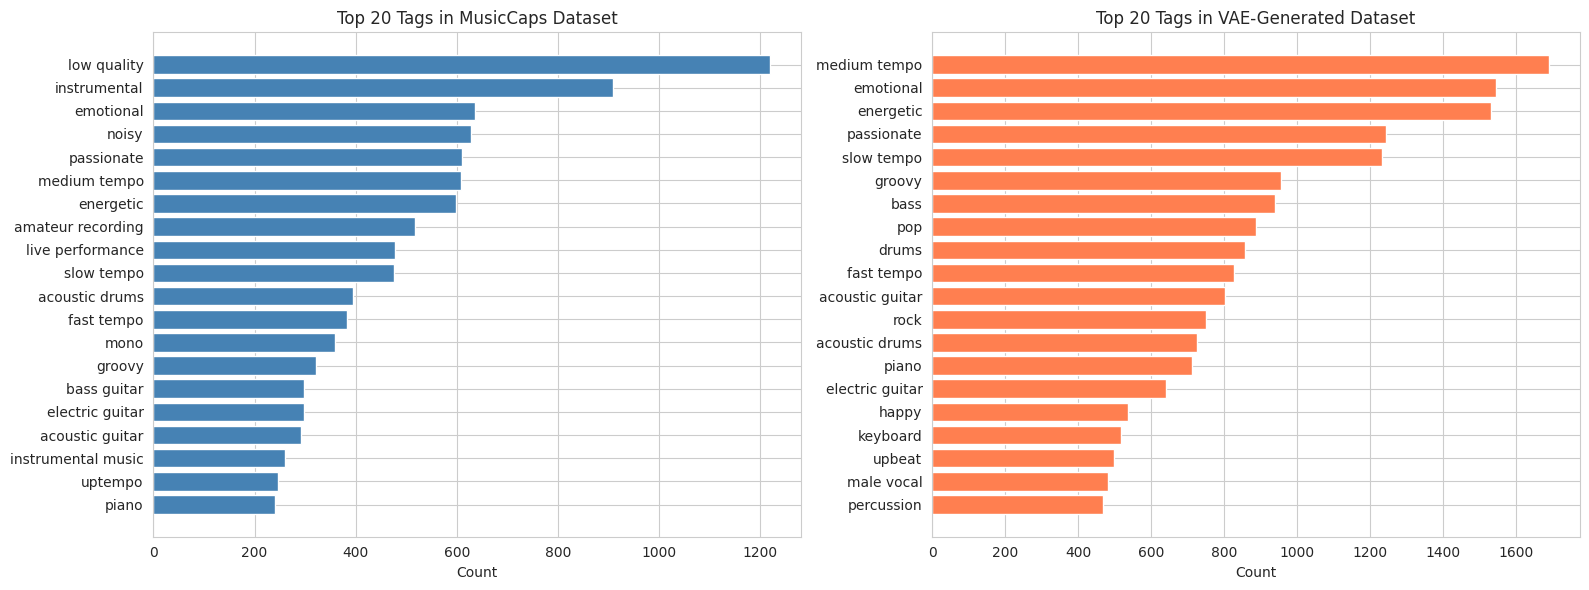

In [19]:
# Plot most popular tags in each dataset
def get_top_tags(df, col, top_k=10):
    all_tags = [tag for tags in df[col] for tag in tags]
    tag_counts = Counter(all_tags)
    return tag_counts.most_common(top_k)
top_k = 20
top_tags_mc = get_top_tags(df_mc, 'aspect_list', top_k=top_k)
top_tags_vae = get_top_tags(df_vae_baseline, 'aspect_list', top_k=top_k)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].barh([tag for tag, _ in top_tags_mc][::-1], [count for _, count in top_tags_mc][::-1], color='steelblue')
axes[0].set_title('Top 20 Tags in MusicCaps Dataset')
axes[0].set_xlabel('Count')
axes[1].barh([tag for tag, _ in top_tags_vae][::-1], [count for _, count in top_tags_vae][::-1], color='coral')
axes[1].set_title('Top 20 Tags in VAE-Generated Dataset')
axes[1].set_xlabel('Count')
plt.tight_layout()
plt.show()

## Compare Individual Tag Distributions

Analyze how specific tags (genre, instrument, mood) are distributed in each dataset to assess if VAE generation preserves individual tag frequencies.

In [11]:
# Flatten all tags and count occurrences
from collections import Counter

tag_type_comparisons = []

# Helper function to get all tags from a column
def get_all_tags(df, column):
    all_tags = []
    for tag_list in df[column]:
        all_tags.extend(tag_list)
    return all_tags

# Compare each tag category - using ALL temperatures in VAE dataset
categories_to_compare = [
    ('Genre', 'genre_tags'),
    ('Instrument', 'instrument_tags'),
    ('Mood', 'mood_tags'),
    ('Tempo', 'tempo_tags')
]

tag_comparison_results = {}

df_vae_all = df_vae.reset_index(drop=True)

for cat_name, col_name in categories_to_compare:
    train_tags = get_all_tags(df_mc, col_name)
    vae_tags = get_all_tags(df_vae_all, col_name)

    train_counter = Counter(train_tags)
    vae_counter = Counter(vae_tags)
    
    # Get all unique tags
    all_unique_tags = set(train_counter.keys()) | set(vae_counter.keys())
    
    # Create comparison dataframe with percentages
    comparison_data = []
    for tag in sorted(all_unique_tags):
        train_count = train_counter.get(tag, 0)
        vae_count = vae_counter.get(tag, 0)
        train_percentage = (train_count / len(train_tags) * 100) if len(train_tags) > 0 else 0
        vae_percentage = (vae_count / len(vae_tags) * 100) if len(vae_tags) > 0 else 0
        
        comparison_data.append({
            'Tag': tag,
            'MusicCaps Count': train_count,
            'VAE Count': vae_count,
            'MusicCaps %': train_percentage,
            'VAE %': vae_percentage,
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    tag_comparison_results[cat_name] = comparison_df

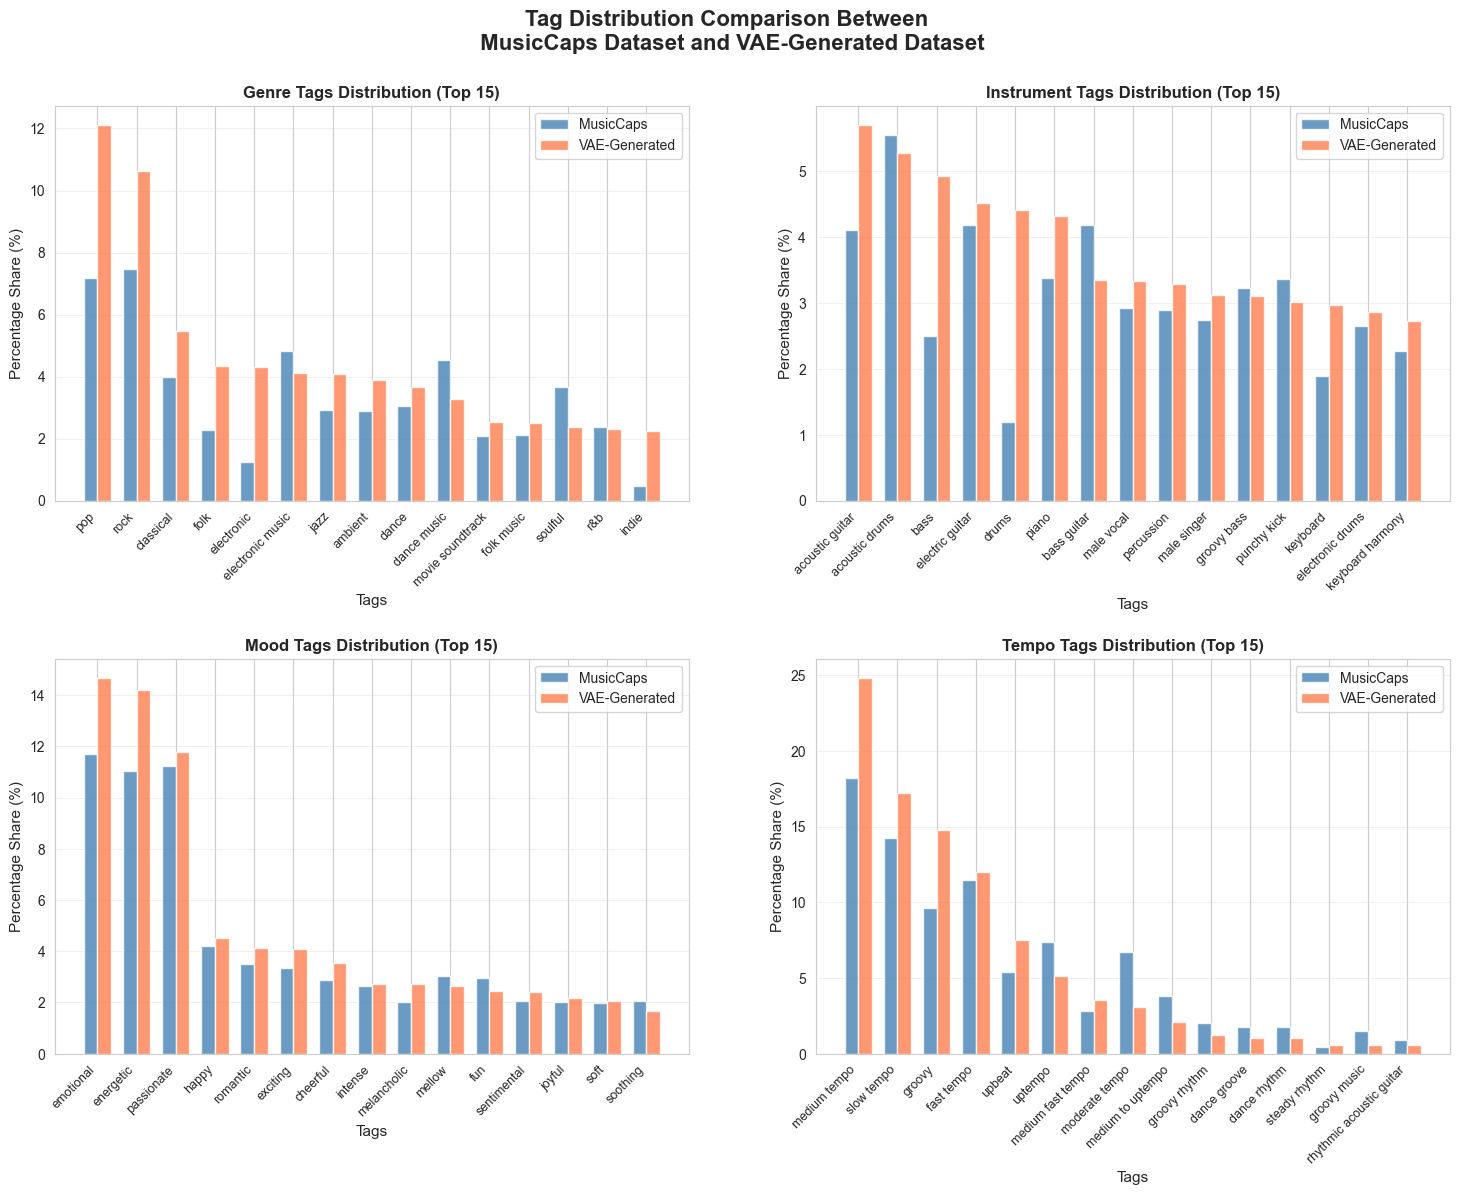

In [13]:
# Create visualizations comparing tag distributions
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    comparison_df = tag_comparison_results[cat_name]
    
    top_tags = comparison_df.nlargest(15, 'VAE Count')
    
    x = np.arange(len(top_tags))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, top_tags['MusicCaps %'], width, label='MusicCaps', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, top_tags['VAE %'], width, label='VAE-Generated', color='coral', alpha=0.8)
    
    ax.set_xlabel('Tags', fontsize=11)
    ax.set_ylabel('Percentage Share (%)', fontsize=11)
    ax.set_title(f'{cat_name} Tags Distribution (Top 15)', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top_tags['Tag'], rotation=45, ha='right', fontsize=9)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Tag Distribution Comparison Between \n MusicCaps Dataset and VAE-Generated Dataset', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.savefig("../docs/assets/tag_distribution_comparison.pdf", bbox_inches='tight')
plt.show()

## Compare Category-wise Tag Counts


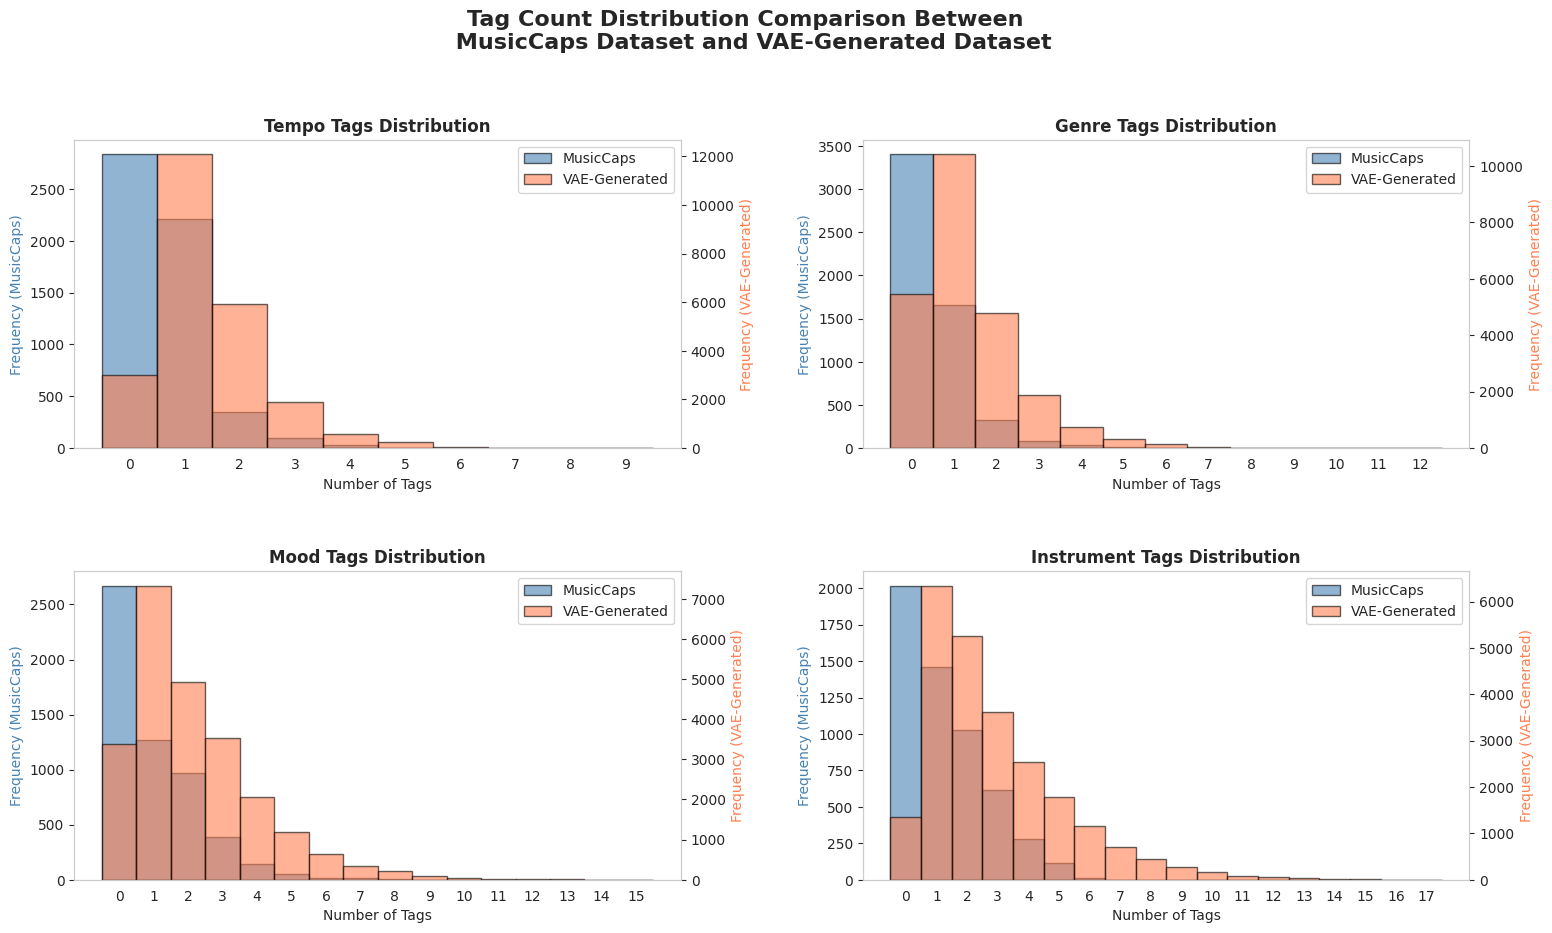

In [22]:
_tag_categories = {
    'Tempo': 'tempo_tags',
    'Genre': 'genre_tags',
    'Mood': 'mood_tags',
    'Instrument': 'instrument_tags',
}
fig, axes = plt.subplots(2, len(_tag_categories) // 2, figsize=(18, 10))
axes = axes.flatten()

for idx, (cat_name, col) in enumerate(_tag_categories.items()):
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    train_counts = df_mc[col].apply(len)
    vae_counts = df_vae_all[col].apply(len)
    
    # Create bins
    max_count = max(train_counts.max(), vae_counts.max())
    bins = np.arange(0, max_count + 2)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot histograms
    n1, _, patches1 = ax1.hist(train_counts, bins=bins, alpha=0.6, label='MusicCaps', color='steelblue', edgecolor='black')
    n2, _, patches2 = ax2.hist(vae_counts, bins=bins, alpha=0.6, label='VAE-Generated', color='coral', edgecolor='black')
    
    # Center x-axis labels to bars
    ax1.set_xticks(bin_centers)
    ax1.set_xticklabels([int(x) for x in bin_centers], rotation=0)
    
    ax1.set_xlabel('Number of Tags')
    ax1.set_ylabel('Frequency (MusicCaps)', color='steelblue')
    ax2.set_ylabel('Frequency (VAE-Generated)', color='coral')
    ax1.set_title(f'{cat_name} Tags Distribution', fontsize=12, fontweight='bold')
    
    handles = [patches1[0], patches2[0]]
    labels = ['MusicCaps', 'VAE-Generated']

    ax1.grid(False)
    ax2.grid(False)
    ax1.legend(handles, labels, loc='upper right')

fig.suptitle('Tag Count Distribution Comparison Between \n MusicCaps Dataset and VAE-Generated Dataset', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.85, hspace=0.4, wspace=0.3)
plt.show()

/tmp/ipykernel_10265/3443064430.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
/tmp/ipykernel_10265/3443064430.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
/tmp/ipykernel_10265/3443064430.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
/tmp/ipykernel_10265/3443064430.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has 

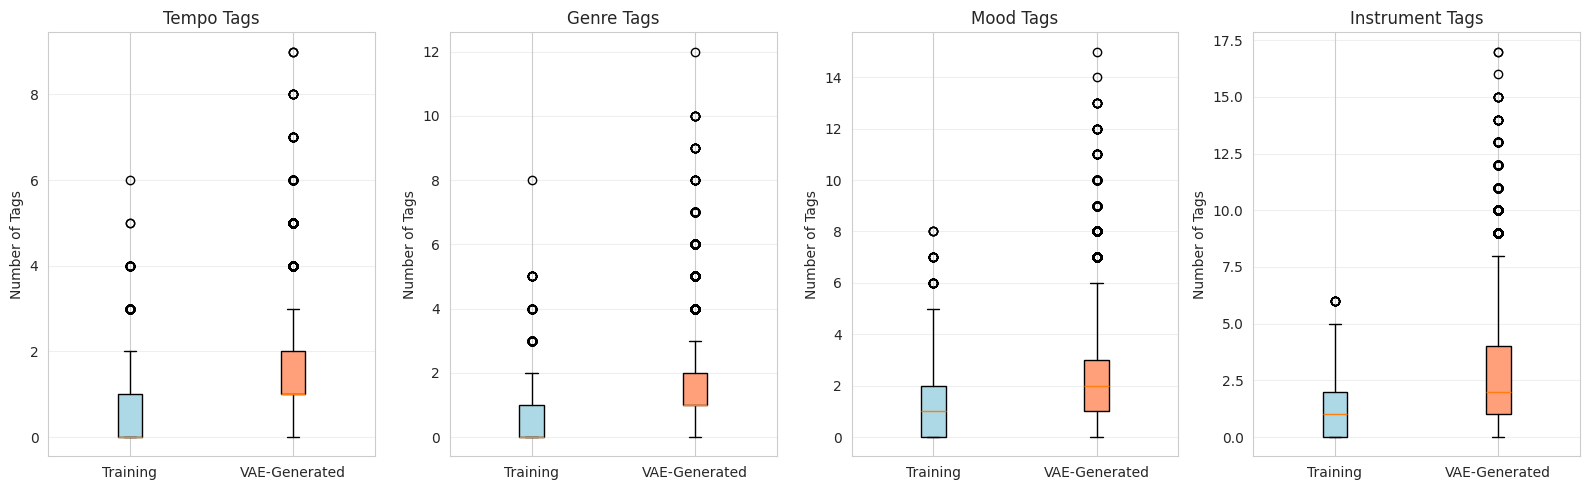

Box plot comparison created successfully


In [23]:

# Create box plots for detailed distribution comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for idx, (cat_name, col) in enumerate(_tag_categories.items()):
    ax = axes[idx]
    
    train_counts = df_mc[col].apply(len)
    vae_counts = df_vae_all[col].apply(len)
    
    data_to_plot = [train_counts, vae_counts]
    bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightsalmon']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel('Number of Tags')
    ax.set_title(f'{cat_name} Tags')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Box plot comparison created successfully")


## Analyze Tag Correlation Matrices


In [24]:

# Compute correlation matrices
train_tag_counts = pd.DataFrame({
    'Tempo': df_mc['tempo_tags'].apply(len),
    'Genre': df_mc['genre_tags'].apply(len),
    'Mood': df_mc['mood_tags'].apply(len),
    'Instrument': df_mc['instrument_tags'].apply(len)
})

vae_tag_counts = pd.DataFrame({
    'Tempo': df_vae_baseline['tempo_tags'].apply(len),
    'Genre': df_vae_baseline['genre_tags'].apply(len),
    'Mood': df_vae_baseline['mood_tags'].apply(len),
    'Instrument': df_vae_baseline['instrument_tags'].apply(len)
})

train_corr = train_tag_counts.corr()
vae_corr = vae_tag_counts.corr()

print("\n" + "="*100)
print("CORRELATION MATRIX - TRAINING DATASET")
print("="*100)
print(train_corr.round(3))

print("\n" + "="*100)
print("CORRELATION MATRIX - VAE-GENERATED DATASET")
print("="*100)
print(vae_corr.round(3))

print("\n" + "="*100)
print("CORRELATION DIFFERENCE (VAE - Training)")
print("="*100)
print((vae_corr - train_corr).round(3))



CORRELATION MATRIX - TRAINING DATASET
            Tempo  Genre   Mood  Instrument
Tempo       1.000  0.181  0.115       0.127
Genre       0.181  1.000  0.143       0.051
Mood        0.115  0.143  1.000      -0.005
Instrument  0.127  0.051 -0.005       1.000

CORRELATION MATRIX - VAE-GENERATED DATASET
            Tempo  Genre   Mood  Instrument
Tempo       1.000  0.089  0.017       0.045
Genre       0.089  1.000  0.064      -0.026
Mood        0.017  0.064  1.000      -0.083
Instrument  0.045 -0.026 -0.083       1.000

CORRELATION DIFFERENCE (VAE - Training)
            Tempo  Genre   Mood  Instrument
Tempo       0.000 -0.092 -0.098      -0.082
Genre      -0.092  0.000 -0.079      -0.077
Mood       -0.098 -0.079  0.000      -0.078
Instrument -0.082 -0.077 -0.078       0.000


## Visualize Distribution Differences


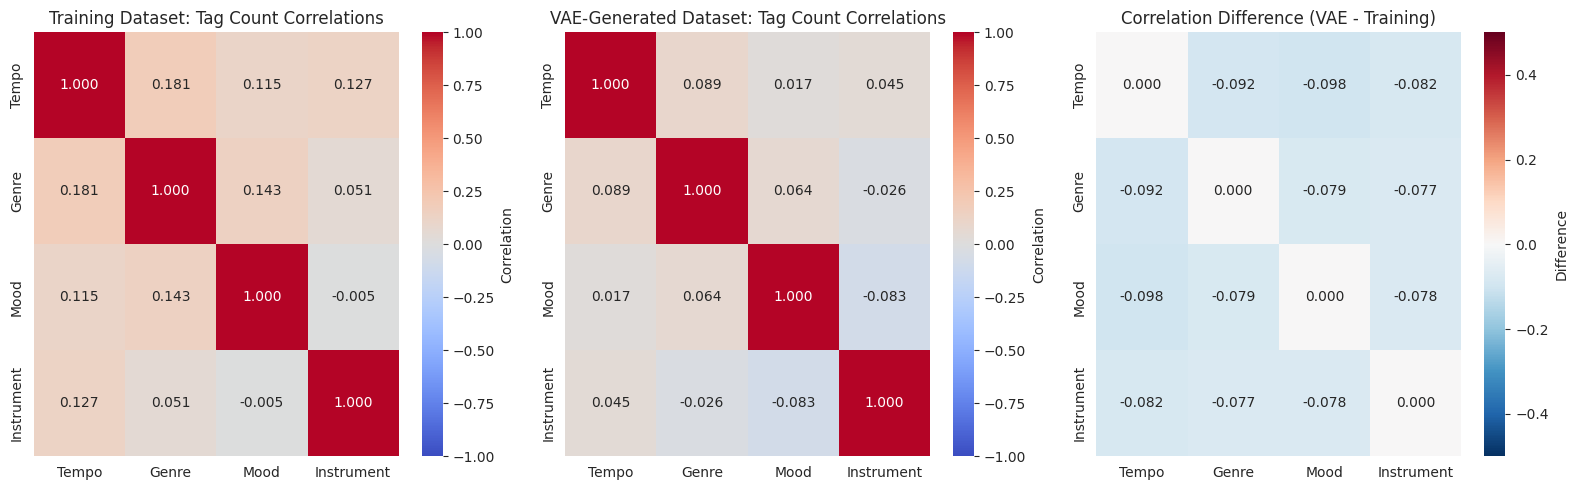

Correlation heatmaps created successfully


In [25]:

# Create correlation heatmaps side-by-side
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Training dataset correlation
sns.heatmap(train_corr, annot=True, fmt='.3f', cmap='coolwarm', vmin=-1, vmax=1, 
            ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Training Dataset: Tag Count Correlations')

# VAE-generated dataset correlation
sns.heatmap(vae_corr, annot=True, fmt='.3f', cmap='coolwarm', vmin=-1, vmax=1,
            ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('VAE-Generated Dataset: Tag Count Correlations')

# Difference
sns.heatmap(vae_corr - train_corr, annot=True, fmt='.3f', cmap='RdBu_r', vmin=-0.5, vmax=0.5,
            ax=axes[2], cbar_kws={'label': 'Difference'})
axes[2].set_title('Correlation Difference (VAE - Training)')

plt.tight_layout()
plt.show()

print("Correlation heatmaps created successfully")
